# Million Songs Dataset
Analysis and Statistical Modeling

1. [Description/ Load](#Data-Columns-Decscription)

2. [Analysis](#Analyses)

1. [Modeling](#Modeling)

## Data Columns Decscription
- **Feature: column name**
- artist name: a_ 
- artist id: a_id
- artist familiarity: a_fam
- artist latitude: a_lat
- artist longitude: a_lon
- artist hotttnesss: a_hot
- song hotttnesss: s_hot
- title: s_
- song id: s_id
- key: s_key
- mode: s_mode
- year: s_year
- duration: s_dur
- end of fade in: s_fade_in
- start of fade_out: s_fade_out
- tempo: s_tempo
- loudness: s_loud
- mode confidence: s_mode_conf
- time signature: s_tsig
- time signature_confidence: s_ts_conf
- track id: tr_id
- user tags: tag_XXX

## Load

In [27]:
# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.joblib import parallel_backend
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data handling and statistics
import statsmodels.formula.api as smf
from scipy import interp
import pandas as pd
import numpy as np
import patsy

# Other
from pprint import pprint as pp
import itertools
import os

%matplotlib inline
sns.set()
float_formatter = lambda x: "%.4f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.set_option('display.float_format', float_formatter)
pd.options.display.max_columns = 999

In [2]:
# Load data from previous cleaning notebook
df1 = pd.read_pickle('data/model1_df.pickle')
df2 = pd.read_pickle('data/model2_df.pickle')
df = pd.concat([df1, df2])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 994448 entries, 0 to 998159
Columns: 2348 entries, tr_id to tag_香港歌手
dtypes: category(2), float64(12), int16(1), int8(2327), object(3), uint8(3)
memory usage: 2.3+ GB


In [3]:
print(df.columns[:34])

identifiers = df.loc[:,['tr_id', 's_id', 'a_id', 'a_', 's_']]
identifiers.to_pickle(path = 'data/id_df.pickle')

df.set_index('s_id', inplace=True)
df.drop(['tr_id', 'a_id', 'a_', 's_'], axis=1, inplace=True)

corr_df = df.iloc[:,:29].copy()

y = df.loc[:,['alternative', 'country', 'electronic', 'folk', 'funk', 'hiphop',
             'jazz', 'metal', 'other', 'pop', 'punk', 'reggae', 'rock']]

X = df.drop(['alternative', 'country', 'electronic', 'folk', 'funk', 'hiphop',
             'jazz', 'metal', 'other', 'pop', 'punk', 'reggae', 'rock'], axis=1)

del identifiers

Index(['tr_id', 's_', 's_id', 'a_', 'a_id', 's_key', 's_mode', 's_tsig',
       's_dur', 'a_fam', 'a_hot', 's_year', 'a_lat', 'a_lon', 's_hot',
       's_fade_in', 's_loud', 's_mode_conf', 's_fade_out', 's_tempo',
       's_ts_conf', 'alternative', 'country', 'electronic', 'folk', 'funk',
       'hiphop', 'jazz', 'metal', 'other', 'pop', 'punk', 'reggae', 'rock'],
      dtype='object')


## Analyses

In [4]:
counts = df.sum().sort_values(ascending=False)
#counts.head()

In [16]:
corr_df.corr()

,s_key,s_mode,s_tsig,s_dur,a_fam,a_hot,s_year,a_lat,a_lon,s_hot,s_fade_in,s_loud,s_mode_conf,s_fade_out,s_tempo,s_ts_conf,alternative,country,electronic,folk,funk,hiphop,jazz,metal,other,pop,punk,reggae,rock
s_key,1.0000,-0.2017,0.0097,0.0255,0.0021,-0.0006,-0.0023,-0.0114,-0.0114,-0.0019,-0.0032,0.0348,-0.0327,0.0260,0.0170,0.0053,-0.0036,-0.0202,0.0203,-0.0203,0.0055,0.0145,-0.0135,0.0048,-0.0004,-0.0098,0.0079,0.0056,-0.0092
s_mode,-0.2017,1.0000,-0.0329,-0.0708,-0.0071,-0.0038,-0.0063,0.0300,0.0298,-0.0038,-0.0060,-0.0262,0.1269,-0.0710,-0.0082,-0.0374,0.0114,0.0838,-0.0604,0.0589,-0.0167,-0.0408,0.0089,-0.0166,0.0044,0.0289,0.0062,-0.0148,0.0331
s_tsig,0.0097,-0.0329,1.0000,0.1047,0.0391,0.0278,0.0184,-0.0242,-0.0241,0.0213,-0.0060,0.1080,-0.0563,0.1041,0.0491,0.3075,0.0145,-0.0564,0.0613,-0.0545,0.0353,0.0612,-0.0281,0.0055,-0.0033,0.0213,-0.0128,0.0128,-0.0076
s_dur,0.0255,-0.0708,0.1047,1.0000,-0.0066,-0.0019,-0.0214,-0.0301,-0.0299,-0.0194,0.1037,0.0093,-0.0060,0.9979,-0.0158,0.1031,-0.0460,-0.0867,0.1176,-0.0642,0.0316,0.0096,0.0117,-0.0161,-0.0030,-0.0762,-0.0688,-0.0126,-0.0800
a_fam,0.0021,-0.0071,0.0391,-0.0066,1.0000,0.7190,0.3011,0.0965,0.0966,0.2039,0.0045,0.1560,0.0014,-0.0069,0.0279,0.0290,0.3024,0.0491,0.0622,0.0622,0.1513,0.1297,0.0645,0.1940,0.1055,0.2511,0.2052,0.0478,0.2761
a_hot,-0.0006,-0.0038,0.0278,-0.0019,0.7190,1.0000,0.2905,0.0610,0.0612,0.1897,0.0096,0.0960,0.0070,-0.0023,0.0155,0.0193,0.2228,0.0606,0.0435,0.0689,0.1424,0.0877,0.0756,0.1524,0.1287,0.2264,0.1505,0.0428,0.2353
s_year,-0.0023,-0.0063,0.0184,-0.0214,0.3011,0.2905,1.0000,0.0106,0.0108,0.1993,0.0159,0.0842,0.0103,-0.0232,0.0259,0.0019,0.2144,0.0440,0.0577,0.0659,0.0384,0.0350,0.0508,0.1075,0.0557,0.1497,0.1325,0.0136,0.2096
a_lat,-0.0114,0.0300,-0.0242,-0.0301,0.0965,0.0610,0.0106,1.0000,1.0000,0.0191,-0.0018,-0.0834,0.0211,-0.0312,-0.0187,-0.0240,0.0382,0.1277,0.0178,0.0868,0.0838,0.0788,0.1503,0.0165,0.0477,0.0684,0.0390,0.0409,0.1161
a_lon,-0.0114,0.0298,-0.0241,-0.0299,0.0966,0.0612,0.0108,1.0000,1.0000,0.0192,-0.0017,-0.0832,0.0211,-0.0310,-0.0187,-0.0239,0.0384,0.1274,0.0184,0.0868,0.0838,0.0787,0.1501,0.0167,0.0477,0.0687,0.0392,0.0411,0.1163
s_hot,-0.0019,-0.0038,0.0213,-0.0194,0.2039,0.1897,0.1993,0.0191,0.0192,1.0000,0.0053,0.0987,0.0216,-0.0222,0.0279,0.0102,0.1585,0.0104,0.0153,0.0349,-0.0009,0.0300,0.0108,0.0942,0.0252,0.0577,0.0920,-0.0033,0.1182


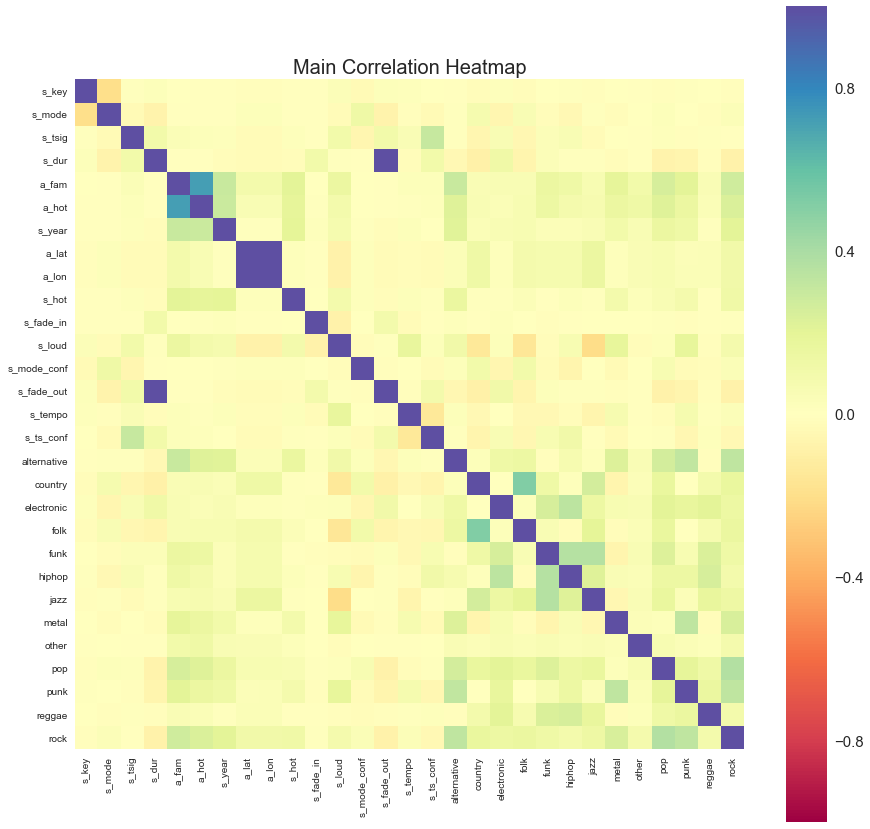

In [8]:
# Correlation heatmap of non-tag data
# Font scale is finicky
plt.subplots(figsize=(15,15))
sns.set()
sns.set(font_scale=1.5)

fig = sns.heatmap(corr_df.corr(), square=True, cmap='Spectral')
fig.set_title('Main Correlation Heatmap', fontdict={'fontsize': 20});

#### Multicolinearity:
1. Artist Hotttnesss & Artist Familiartiy
2. Song Beginning of Fade Out & Song Duration

#### Biggest overlap(s):

1. alternative
    - weak: metal, pop
    - mild: punk, rock
2. country
    - moderate: folk
3. electronic
    - weak: funk, pop, reggae
    - mild: hip hop
4. folk
    - weak: jazz
    - moderate: country
5. funk
    - weak: electronic, pop, reggae 
    - mild: hip hop, jazz
6. hiphop
    - weak: jazz, reggae
    - mild: electronic, funk
7. jazz
    - weak: country, folk, hip hop
    - mild: funk
8. metal
    - weak: alternative, rock
    - mild: punk
9. other
    - None
10. pop 
    - weak: alternative, electronic, funk
    - mild: rock
11. punk
    - weak: pop
    - mild: alternative, metal, rock
12. reggae 
    - weak: hip hop, funk, electronic
13. rock 
    - weak: metal
    - mild: alternative, pop, punk

In [17]:
# Train test splits with a validation set
X_tr, X_holdout, y_tr, y_holdout = train_test_split(X, y, test_size=0.20, 
                                                    random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_tr, 
                                                            y_tr,
                                                            test_size=0.20,
                                                            random_state=42)

In [18]:
print('Feature size:', X.shape)
print('Target size:', y.shape)

print('Feature Training:', X_train.shape)
print('Target Training:', y_train.shape)

print('Feature Validation:', X_validate.shape)
print('Target Validation:', y_validate.shape)

print('Feature Testing size:', X_holdout.shape)
print('Target Testing size:', y_holdout.shape)

Feature size: (994448, 2330)
Target size: (994448, 13)
Feature Training: (636446, 2330)
Target Training: (636446, 13)
Feature Validation: (159112, 2330)
Target Validation: (159112, 13)
Feature Testing size: (198890, 2330)
Target Testing size: (198890, 13)


In [19]:
# Reviewing class imbalances for full set
class_ = (y.sum()/len(df.index)).sort_values(ascending=False)
names = list(class_.index)
proportions = list(class_.data)
class_imbalances = list(zip(names, proportions))

# Reviewing class imbalances for training subset
class_ss = (y_train.sum()/len(y_train.index)).sort_values(ascending=False)
names_ss = list(class_ss.index)
proportions_ss = list(class_ss.data)
class_imbalances_ss = list(zip(names_ss, proportions_ss))

subset_size = len(y_train.index)/len(df.index)*100
print(f'Modelling with {subset_size:{0}.{4}}% of the full dataset')
print('Full set imbalance \t\t Subset imbalance')
list(zip(class_imbalances, class_imbalances_ss))

Modelling with 64.0% of the full dataset
Full set imbalance 		 Subset imbalance


[(('other', 0.9940409151609737), ('other', 0.9940120607247119)),
 (('rock', 0.767776696217399), ('rock', 0.7674586689208511)),
 (('pop', 0.6686402908950493), ('pop', 0.6687825832827923)),
 (('electronic', 0.6446410470934629), ('electronic', 0.6444584458068713)),
 (('jazz', 0.470431837562145), ('jazz', 0.46987961272441026)),
 (('hiphop', 0.44544913358968996), ('hiphop', 0.4453245051426201)),
 (('funk', 0.43207890206426075), ('funk', 0.43186538999380936)),
 (('punk', 0.406935304812318), ('punk', 0.40710759435993)),
 (('alternative', 0.4026032532621112), ('alternative', 0.4019696879232488)),
 (('folk', 0.29202934693417854), ('folk', 0.29149212973292316)),
 (('metal', 0.269710432320242), ('metal', 0.2692624354619245)),
 (('country', 0.25479663089472754), ('country', 0.2542886592106793)),
 (('reggae', 0.19937090727720302), ('reggae', 0.19966344356001922))]

## Modeling

In [20]:
# Playing with the stats model formula
"""'s_key', 's_mode', 's_tsig',
's_dur', 'a_fam', 'a_hot', 's_year', 'a_lat', 'a_lon', 's_hot',
's_fade_in', 's_loud', 's_mode_conf', 's_fade_out', 's_tempo',
's_ts_conf'""";

formula1 = '1 ~ 1 + s_key + s_mode'

formula2 = '1 ~ 1 + s_key + s_mode + s_tsig + s_dur + a_fam + a_hot + s_year + \
                a_lat + a_lon + s_hot + s_fade_in + s_loud + s_mode_conf + \
                s_fade_out + s_tempo + s_ts_conf'


_, X_pat = patsy.dmatrices(formula2, data=X, return_type="dataframe")
print(np.linalg.matrix_rank(X_pat.values))

17


In [21]:
# Test genres, checking p-values
#genres = list(y.columns)
genres = ['rock', 'jazz']

# ONE vs. REST
for genre in genres:
    logit = smf.Logit(y[genre], X_pat)
    result = logit.fit(method='newton', maxiter=5000)
    print(result.summary()) # Summary of model
    params = result.params
    conf = result.conf_int() # Look at conf_interval for each coef
    conf['OR'] = params
    conf.columns = ['2.5%', '97.5%', 'OR']
    print(np.exp(conf)) # Odds Ratio transformation for interpretability

Optimization terminated successfully.
         Current function value: 0.480342
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   rock   No. Observations:               994448
Model:                          Logit   Df Residuals:                   994431
Method:                           MLE   Df Model:                           16
Date:                Fri, 23 Feb 2018   Pseudo R-squ.:                  0.1137
Time:                        18:47:15   Log-Likelihood:            -4.7768e+05
converged:                       True   LL-Null:                   -5.3894e+05
                                        LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.2499      0.023    -10.751      0.000      -0.295      -0.204
s_key          -0.0016    

In [25]:
%%time

# Testing class weighting, which varies for each genre
genre = 'rock'
cols = 16 # base
#cols = cols = X_train.shape[1] + 1 # Max columnss

# Initializing LR
logreg   = LogisticRegression()
logreg_w1= LogisticRegression(class_weight={0:1, 1:1})
logreg_w2= LogisticRegression(class_weight={0:2, 1:1})
logreg_w3= LogisticRegression(class_weight={0:3.3, 1:1})
logreg_w4= LogisticRegression(class_weight={0:5, 1:1})
logreg_w5= LogisticRegression(class_weight={0:10, 1:1})
logreg_b = LogisticRegression(class_weight='balanced')

# Fitting LR
logreg.fit(   X_train.iloc[:,:cols], y_train[genre])
logreg_w1.fit(X_train.iloc[:,:cols], y_train[genre])
logreg_w2.fit(X_train.iloc[:,:cols], y_train[genre])
logreg_w3.fit(X_train.iloc[:,:cols], y_train[genre])
logreg_w4.fit(X_train.iloc[:,:cols], y_train[genre])
logreg_w5.fit(X_train.iloc[:,:cols], y_train[genre])
logreg_b.fit( X_train.iloc[:,:cols], y_train[genre])

# Predicting for later scoring on validation set
y_pred   = logreg.predict(   X_validate.iloc[:,:cols])
y_pred_w1= logreg_w1.predict(X_validate.iloc[:,:cols])
y_pred_w2= logreg_w2.predict(X_validate.iloc[:,:cols])
y_pred_w3= logreg_w3.predict(X_validate.iloc[:,:cols])
y_pred_w4= logreg_w4.predict(X_validate.iloc[:,:cols])
y_pred_w5= logreg_w5.predict(X_validate.iloc[:,:cols])
y_pred_b = logreg_b.predict( X_validate.iloc[:,:cols])

# Probability predictions for our scoring metric of interest- ROC AUC
y_proba    = logreg.predict_proba(   X_validate.iloc[:,:cols])[:,1]
y_proba_w1 = logreg_w1.predict_proba(X_validate.iloc[:,:cols])[:,1]
y_proba_w2 = logreg_w2.predict_proba(X_validate.iloc[:,:cols])[:,1]
y_proba_w3 = logreg_w3.predict_proba(X_validate.iloc[:,:cols])[:,1]
y_proba_w4 = logreg_w4.predict_proba(X_validate.iloc[:,:cols])[:,1]
y_proba_w5 = logreg_w5.predict_proba(X_validate.iloc[:,:cols])[:,1]
y_proba_b  = logreg_b.predict_proba( X_validate.iloc[:,:cols])[:,1]

CPU times: user 1min 25s, sys: 1.65 s, total: 1min 27s
Wall time: 1min 27s


In [26]:
# Ultra baseline is mean scoring to make us feel good about the models
mean_pred = np.random.binomial(1, proportions_ss[1], len(y_validate[genre]))
mean_proba = np.repeat(proportions_ss[1], len(y_validate[genre]))

print('Mean Proportion Test F1: %.3f, Test AUC: %.3f, Accuracy: %.3f' % \
      (f1_score(y_validate[genre], mean_pred), 
       roc_auc_score(y_validate[genre], mean_proba),
       accuracy_score(y_validate[genre], mean_pred)))

print('Normal Logistic Regression Test F1: %.3f, Test AUC: %.3f, Accuracy: %.3f' % \
      (f1_score(y_validate[genre], y_pred), 
       roc_auc_score(y_validate[genre], y_proba),
       accuracy_score(y_validate[genre], y_pred)))

print('Weighted1 Logistic Regression Test F1: %.3f, Test AUC: %.3f, Accuracy: %.3f' % \
      (f1_score(y_validate[genre], y_pred_w1), 
       roc_auc_score(y_validate[genre], y_proba_w1),
       accuracy_score(y_validate[genre], y_pred_w1)))

print('Weighted2 Logistic Regression Test F1: %.3f, Test AUC: %.3f, Accuracy: %.3f' % \
      (f1_score(y_validate[genre], y_pred_w2), 
       roc_auc_score(y_validate[genre], y_proba_w2),
       accuracy_score(y_validate[genre], y_pred_w2)))

print('Weighted3 Logistic Regression Test F1: %.3f, Test AUC: %.3f, Accuracy: %.3f' % \
      (f1_score(y_validate[genre], y_pred_w3), 
       roc_auc_score(y_validate[genre], y_proba_w3),
       accuracy_score(y_validate[genre], y_pred_w3)))

print('Weighted4 Logistic Regression Test F1: %.3f, Test AUC: %.3f, Accuracy: %.3f' % \
      (f1_score(y_validate[genre], y_pred_w4), 
       roc_auc_score(y_validate[genre], y_proba_w4),
       accuracy_score(y_validate[genre], y_pred_w4)))

print('Weighted5 Logistic Regression Test F1: %.3f, Test AUC: %.3f, Accuracy: %.3f' % \
      (f1_score(y_validate[genre], y_pred_w5), 
       roc_auc_score(y_validate[genre], y_proba_w5),
       accuracy_score(y_validate[genre], y_pred_w5)))

print('Balanced Logistic Regression Test F1: %.3f, Test AUC: %.3f, Accuracy: %.3f' % \
      (f1_score(y_validate[genre], y_pred_b), 
       roc_auc_score(y_validate[genre], y_proba_b),
       accuracy_score(y_validate[genre], y_pred_b)))

Mean Proportion Test F1: 0.768, Test AUC: 0.500, Accuracy: 0.644
Normal Logistic Regression Test F1: 0.868, Test AUC: 0.682, Accuracy: 0.768
Weighted1 Logistic Regression Test F1: 0.868, Test AUC: 0.681, Accuracy: 0.768
Weighted2 Logistic Regression Test F1: 0.845, Test AUC: 0.731, Accuracy: 0.760
Weighted3 Logistic Regression Test F1: 0.764, Test AUC: 0.731, Accuracy: 0.678
Weighted4 Logistic Regression Test F1: 0.589, Test AUC: 0.705, Accuracy: 0.529
Weighted5 Logistic Regression Test F1: 0.191, Test AUC: 0.692, Accuracy: 0.308
Balanced Logistic Regression Test F1: 0.763, Test AUC: 0.731, Accuracy: 0.677


In [ ]:
# Grid search for a subset of logistic regression for testing 
lr_SUBSET = LogisticRegression(max_iter=10000)

fold = KFold(n_splits=5, shuffle=True)
scoring = {'accuracy': make_scorer(accuracy_score), 'roc_auc': 'roc_auc'}

method_options = ['newton-cg'] #, lbfgs', 'liblinear']
regularization = np.logspace(-3, 3, num=6, base=np.e)
class_weights = [None, 'balanced']
param_grid = dict(solver=method_options, C=regularization, class_weight=class_weights)

grid = GridSearchCV(estimator=lr_SUBSET, param_grid=param_grid, cv=fold, 
                    scoring=scoring, verbose=3, refit='roc_auc', 
                    return_train_score=False)

# Tried multithreading but n_jobs reset to 1 everytime
with parallel_backend('threading'):
    grid.fit(X_pat, y_temp['rock'])

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[24856 12105]
 [39348 82803]]
Normalized confusion matrix
[[0.6725 0.3275]
 [0.3221 0.6779]]


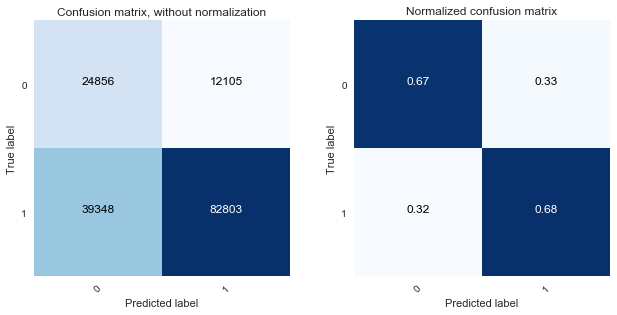

In [30]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_validate[genre], y_pred_b)

# Plot non-normalized confusion matrix
fig = plt.figure()
plt.subplot(121)
plt.grid()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122)
plt.grid()
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')

plt.subplots_adjust(left=0.25, right=1.25, bottom=0.0, top=1.25, 
                    hspace=0.25, wspace=.25)

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes, fig=1, figsize=(14,6), ylim=None, cv=6, scoring='accuracy'):
    # Learning curve
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            train_sizes=np.arange(.1,1,.05),
                                                            scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Figure Settings
    plt.figure(num=fig, figsize=figsize)
    ax = plt.subplot(axes)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    best_test = test_scores_mean[-1]
    worst_train = train_scores_mean[-1]

    area = sum((train_scores_mean - test_scores_mean) * train_sizes)
    print(f"{title} variance score: {area:{width}.{precision}}")
    ax.axhline(best_test, color='g', linestyle='dashed', linewidth=2)
    ax.axhline(worst_train, color='r', linestyle='dashed', linewidth=2)

    # Error shading
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.15, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.15, color="g")
    plt.fill_between(train_sizes, train_scores_mean, test_scores_mean, alpha=0.075, color="k")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.legend(loc="lower right")
    return plt

In [ ]:
fold = KFold(n_splits=2, shuffle=True)

dtc = DecisionTreeClassifier()
criterion = ['entropy'] #'gini
maxfeat = list(range(4, 20))
maxdepth = list(range(2, 18))
mininfo = [0.0]
minsamp = list(range(180,300,2))
param_grid = dict(max_features=maxfeat, max_depth=maxdepth, criterion=criterion, 
                  min_samples_leaf=minsamp, min_impurity_decrease=mininfo)
grid = GridSearchCV(estimator = dtc, param_grid=param_grid, cv=fold, scoring='roc_auc', verbose=2, n_jobs=-1)

grid.fit(X_validate, y_validate['rock'])

In [ ]:
print(genre)
bTree2 = grid2.best_estimator_

bTree2.fit(X_train, y_train[genre])

dt2_y_pred = bTree2.predict(X_holdout)
dt2_y_proba= bTree2.predict_proba(X_holdout)[:,1]

print('Decision Tree Test F1: %.3f, Test AUC: %.3f, Accuracy: %.3f' % \
      (f1_score(y_holdout[genre], dt2_y_pred), 
       roc_auc_score(y_holdout[genre], dt2_y_proba),
       accuracy_score(y_holdout[genre], dt2_y_pred)))

In [ ]:
print('Grid Decision:')
pp(grid.decision_function)

print('-'*80)
print('*'*80)
print('-'*80)

print('Scoring Type:')
pp(grid.scorer_)

print('-'*80)
print('*'*80)
print('-'*80)

print('Best Score:')
pp(grid.best_score_)

print('-'*80)
print('*'*80)
print('-'*80)

print('Best Parameters:')
pp(grid.best_params_)

print('-'*80)
print('*'*80)
print('-'*80)

print('Best Estimator:')
pp(grid.best_estimator_)

print('-'*80)
print('*'*80)
print('-'*80)

print('Search Parameters:')
pp(grid.get_params)

print('-'*80)
print('*'*80)
print('-'*80)

print('CV Results:')
pp(grid.cv_results_)

print('-'*80)
print('*'*80)
print('-'*80)

print('Scores:')
pp(grid.grid_scores_)

print('-'*80)
print('*'*80)
print('-'*80)

print('Predict:')
pp(type(grid.predict))

In [31]:
# Run classifier with cross-validation and plot ROC curves
def roc_auc(model, X, y, name, axes, fig=1, figsize=(12,12), color='b', width=1, precision=4, n_splits=2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4444)
    cv = StratifiedKFold(n_splits=n_splits)
    
    tp_rates = []
    aucs = []
    mean_fp_rate = np.linspace(0, 1, 100)

    plt.figure(num=fig, figsize=figsize)
    ax = plt.subplot(axes)
    
    i = 0
    for train, test in cv.split(X_train, y_train):
        probas_ = model.fit(X_train, y_train).predict_proba(X_test)
        
        # Compute ROC curve and area the curve
        fp_rate, tp_rate, thresholds = roc_curve(y_test, probas_[:,1])
        tp_rates.append(interp(mean_fp_rate, fp_rate, tp_rate))
        tp_rates[-1][0] = 0.0
        roc_auc = auc(fp_rate, tp_rate)
        aucs.append(roc_auc)
        plt.plot(fp_rate, tp_rate, lw=1, alpha=0.8,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tp_rate = np.mean(tp_rates, axis=0)
    mean_tp_rate[-1] = 1.0
    mean_auc = auc(mean_fp_rate, mean_tp_rate)
    std_auc = np.std(aucs)
    plt.plot(mean_fp_rate, mean_tp_rate, color=color,
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tp_rate = np.std(tp_rates, axis=0)
    tp_rates_upper = np.minimum(mean_tp_rate + std_tp_rate, 1)
    tp_rates_lower = np.maximum(mean_tp_rate - std_tp_rate, 0)
    plt.fill_between(mean_fp_rate, tp_rates_lower, tp_rates_upper, color='grey', alpha=.5,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic {}'.format(name))
    #plt.legend(loc="lower right", fontsize='x-small')
    
    print(f'{name} mean AUC: {mean_auc:{width}.{precision}}')

 mean AUC: 0.6933
 mean AUC: 0.729
 mean AUC: 0.6534
 mean AUC: 0.6563


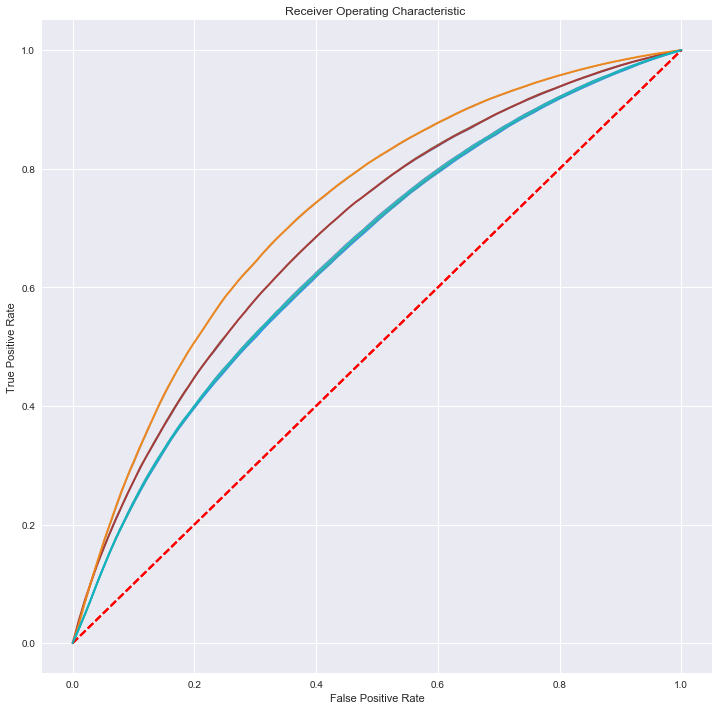

In [34]:
# Plotting the ROC
final_lr = LogisticRegression()
final_lr_bal = LogisticRegression(class_weight='balanced')

genre='rock'
roc_auc(final_lr, X.iloc[:,:16], y[genre], color='firebrick', name='', axes=111)
roc_auc(final_lr_bal, X.iloc[:,:16], y[genre], color='darkorange', name='', axes=111)
#roc_auc(bTree, X.iloc[:,:16], y[genre], color='peru', name='', axes=111)

genre='jazz'
roc_auc(final_lr, X.iloc[:,:16], y[genre], color='dodgerblue', name='', axes=111)
roc_auc(final_lr_bal, X.iloc[:,:16], y[genre], color='c', name='', axes=111)
#roc_auc(bTree, X.iloc[:,:16], y[genre], name='No Tags', axes=111)

In [54]:
cols = 16
genre='rock' # Need to toggle between rock and jazz for final scoring
final_lr_bal.fit(X_train.iloc[:,:cols], y_train[genre])
y_pred_b = final_lr_bal.predict(X_holdout.iloc[:,:cols])
y_proba_b  = final_lr_bal.predict_proba(X_holdout.iloc[:,:cols])[:,1]

print('Balanced Logistic Regression Test F1: %.4f, Test AUC: %.4f, Accuracy: %.4f' % \
      (f1_score(y_holdout[genre], y_pred_b), 
       roc_auc_score(y_holdout[genre], y_proba_b),
       accuracy_score(y_holdout[genre], y_pred_b)))

Balanced Logistic Regression Test F1: 0.7635, Test AUC: 0.7288, Accuracy: 0.6764


In [56]:
cols = cols = X_train.shape[1] + 1
final_lr_bal.fit(X_train.iloc[:,:cols], y_train[genre])
y_pred_b = final_lr_bal.predict(X_holdout.iloc[:,:cols])
y_proba_b  = final_lr_bal.predict_proba(X_holdout.iloc[:,:cols])[:,1]

print('Balanced Logistic Regression Test F1: %.4f, Test AUC: %.4f, Accuracy: %.4f' % \
      (f1_score(y_holdout[genre], y_pred_b), 
       roc_auc_score(y_holdout[genre], y_proba_b),
       accuracy_score(y_holdout[genre], y_pred_b)))

Balanced Logistic Regression Test F1: 0.7616, Test AUC: 0.7753, Accuracy: 0.6808
